## Read and filter the results based on their intersection

In [1]:
import pandas as pd


def load_dataframe(target):
    path_to_csv = "results_faultlocalization/" + target + "/results.csv"
    return pd.read_csv(path_to_csv, index_col=["pid", "bid"])


def filter_dataframe(df):
    return df.loc[df.env & df.checkout & df.compile & df.check_classfiles]

In [2]:
targets = ["default", "java7", "java8", "java11", "java17"]

# Filter each dataframe based on the correctness of compilation results
dfs = {}
for target in targets:
    dfs[target] = filter_dataframe(load_dataframe(target))

# Build the interserction index
index = dfs[targets[0]].index
for i in range(1, len(targets)):
    index = index.intersection(dfs[targets[i]].index)

# Process the dataframes to contain only the intersection
for target in targets:
    dfs[target] = dfs[target].loc[index].sort_index()

# Print the selected bugs
pd.DataFrame(index=dfs[targets[0]].index).to_csv("results_faultlocalization/all_bugs.csv")

## Analyse the results for each target

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

def analyse_results(df, target):
    gzoltar_executed = len(df[df["gzoltar_executed_tests"]==True])
    gzoltar_failing = len(df[df["gzoltar_failing_tests"]==True])
    gzoltar_fl = len(df[df["gzoltar_fl"]==True])
    gzoltar = (gzoltar_executed, gzoltar_failing, gzoltar_fl)

    flacoco_executed = len(df[df["flacoco_executed_tests"]==True])
    flacoco_failing = len(df[df["flacoco_failing_tests"]==True])
    flacoco_fl = len(df[df["flacoco_fl"]==True])
    flacoco = (flacoco_executed, flacoco_failing, flacoco_fl)
    
    ind = np.arange(len(gzoltar))
    width=0.35

    fig, ax = plt.subplots()
    ax.set_ylim([0, len(df)])
    gzoltar_bar = ax.bar(ind - width/2, gzoltar, width, label="GZoltar")
    flacoco_bar = ax.bar(ind + width/2, flacoco, width, label="Flacoco")

    ax.set_ylabel("Count of correct results")
    ax.set_title("Correct results for each task by fault localization tool (target=%s)" % target)
    ax.set_xticks(ind)
    ax.set_xticklabels(("Executed tests", "Failing tests", "Fault localization"))
    ax.legend()

    def autolabel(rects, xpos='center'):
        """
        Attach a text label above each bar in *rects*, displaying its height.
    
        *xpos* indicates which side to place the text w.r.t. the center of
        the bar. It can be one of the following {'center', 'right', 'left'}.
        """

        ha = {'center': 'center', 'right': 'left', 'left': 'right'}
        offset = {'center': 0, 'right': 1, 'left': -1}

        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(offset[xpos]*3, 3),  # use 3 points offset
                        textcoords="offset points",  # in both directions
                        ha=ha[xpos], va='bottom')
        
    autolabel(gzoltar_bar, "center")
    autolabel(flacoco_bar, "center")

    fig.tight_layout()
    plt.show()
    
    intersection = df.loc[df.flacoco_fl & df.gzoltar_fl]
    sns.violinplot(data=[intersection.gzoltar_exec_time, intersection.flacoco_exec_time]).set(ylabel="Execution Time (s)")
    plt.xticks(plt.xticks()[0], ["GZoltar", "Flacoco"])
    plt.title("Execution time (s) per fault localization (target=%s)" % target)
    plt.savefig("%s_exec_time.svg" % target, bbox_inches = "tight")
    plt.show()
    
    plt.hist(intersection["gzoltar_exec_time"] - intersection["flacoco_exec_time"], bins=50)
    plt.title("Histogram of paired differences (target=%s)" % target)
    plt.show()
    
    print(intersection[["gzoltar_exec_time", "flacoco_exec_time"]].describe())
    print(stats.ttest_rel(intersection["gzoltar_exec_time"], intersection["flacoco_exec_time"], alternative="greater"))

In [4]:
print("We are considering %d bugs which we are able to compile down to all LTS target versions." % (len(dfs[targets[0]])))

We are considering 191 bugs which we are able to compile down to all LTS target versions.


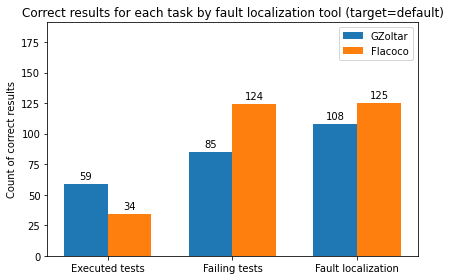

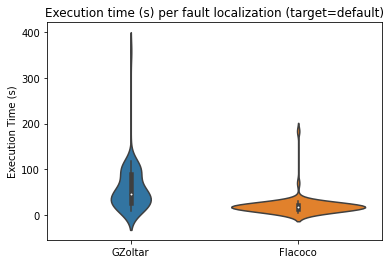

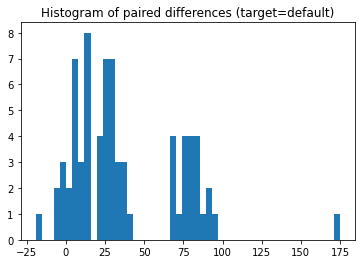

       gzoltar_exec_time  flacoco_exec_time
count          73.000000          73.000000
mean           57.079493          20.162178
std            48.604215          21.241377
min             8.633000           4.424000
25%            25.358000          13.854000
50%            45.387000          17.841000
75%            89.073000          21.924000
max           358.594000         183.469000
Ttest_relResult(statistic=9.056936272687697, pvalue=8.18305476585712e-14)


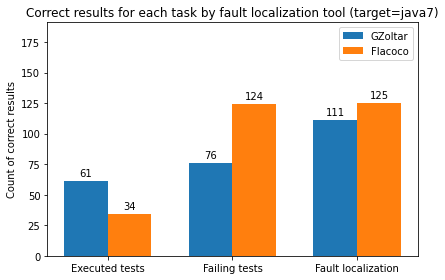

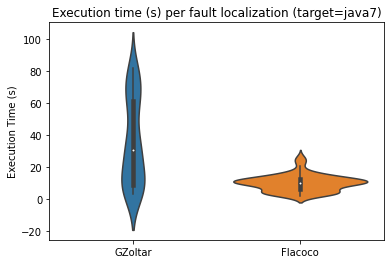

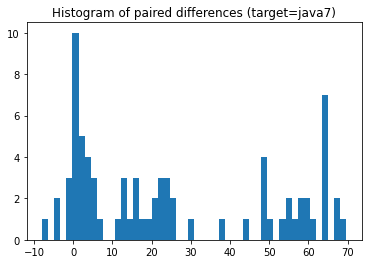

       gzoltar_exec_time  flacoco_exec_time
count          76.000000          76.000000
mean           35.870118          10.253513
std            26.946059           5.097913
min             3.475000           2.269000
25%             8.796250           6.216750
50%            30.721000          10.421000
75%            61.455000          12.495500
max            81.751000          26.542000
Ttest_relResult(statistic=8.912981170298222, pvalue=1.0896588783038138e-13)


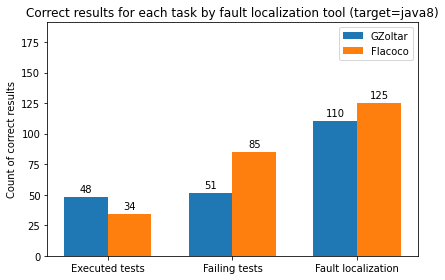

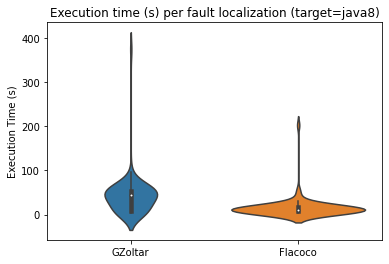

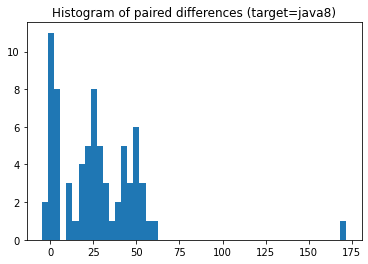

       gzoltar_exec_time  flacoco_exec_time
count          73.000000           73.00000
mean           41.748466           15.29611
std            45.583726           23.98662
min             3.844000            2.46000
25%             8.755000            7.41200
50%            44.271000           11.35900
75%            53.634000           18.07300
max           374.478000          202.61200
Ttest_relResult(statistic=8.8976826057572, pvalue=1.6193453266707122e-13)


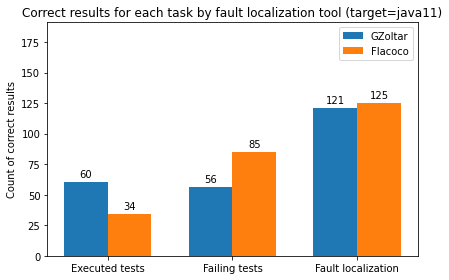

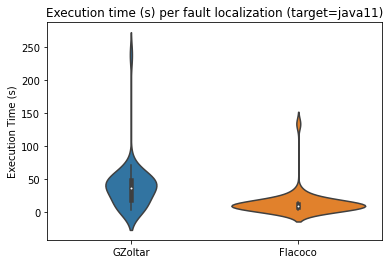

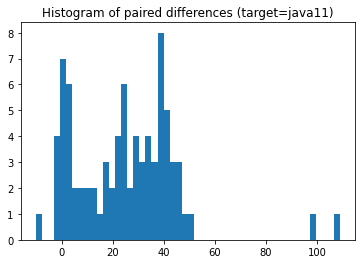

       gzoltar_exec_time  flacoco_exec_time
count          81.000000          81.000000
mean           39.321815          14.443815
std            37.133014          20.117605
min             4.417000           3.047000
25%            18.879000           8.476000
50%            37.794000          10.341000
75%            48.785000          12.736000
max           242.139000         135.783000
Ttest_relResult(statistic=10.916786407594639, pvalue=8.131006195784101e-18)


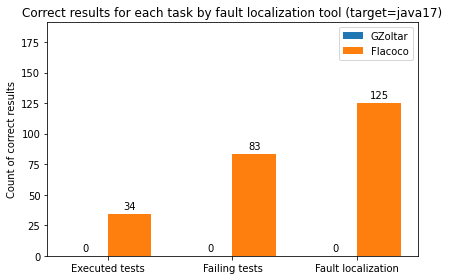

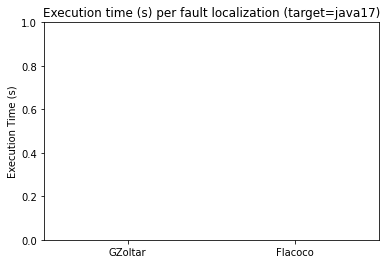

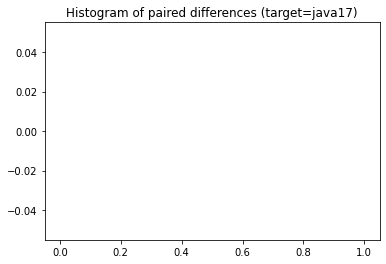

       gzoltar_exec_time  flacoco_exec_time
count                0.0                0.0
mean                 NaN                NaN
std                  NaN                NaN
min                  NaN                NaN
25%                  NaN                NaN
50%                  NaN                NaN
75%                  NaN                NaN
max                  NaN                NaN
Ttest_relResult(statistic=nan, pvalue=nan)


In [5]:
for target in targets:
    analyse_results(dfs[target], target)